In [12]:
%load_ext autoreload
%autoreload 2
from datasets import Dataset, Image, load_dataset, load_from_disk, concatenate_datasets
import os
from transformers import pipeline
import tqdm
import numpy as np
import sys
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import ImageEnhance
sys.path.append("..")
from utils.data_utils import make_hf_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Make new Dataset

In [3]:
# dataset = make_hf_dataset(input_folder='../../data/landsat/inputs', target_folder='../../data/landsat/targets',
#                           masks_folder='../../data/landsat/masks',
#                            save_to_disk=False, dset_location='../../data/landsat/dset.hf')

dataset_dict = make_hf_dataset(src_folder="../../data/landsat_large/")

In [18]:
train_dataset = Dataset.from_dict(dataset_dict['train']).cast_column("input", Image()).cast_column("target", Image())
val_dataset = Dataset.from_dict(dataset_dict['validation']).cast_column("input", Image()).cast_column("target", Image())
test_dataset = Dataset.from_dict(dataset_dict['test']).cast_column("input", Image()).cast_column("target", Image())

train_dataset.save_to_disk('../../data/landsat_large/train')
val_dataset.save_to_disk('../../data/landsat_large/val')
test_dataset.save_to_disk('../../data/landsat_large/test')



Saving the dataset (1/1 shards): 100%|██████████| 2353/2353 [00:19<00:00, 122.41 examples/s]


In [23]:
def brighten_targets(data):
    data['target'] = ImageEnhance.Brightness(data['target']).enhance(2.6)
    return data

In [24]:
train_dataset = train_dataset.map(brighten_targets)
val_dataset = val_dataset.map(brighten_targets)
test_dataset = test_dataset.map(brighten_targets)

Map: 100%|██████████| 2353/2353 [00:58<00:00, 40.22 examples/s] 


In [25]:
train_dataset.push_to_hub("Kornberg/landsat_captions", split="train", token=os.environ['HF_ACCESS_TOKEN'])
val_dataset.push_to_hub("Kornberg/landsat_captions", split="val", token=os.environ['HF_ACCESS_TOKEN'])
test_dataset.push_to_hub("Kornberg/landsat_captions", split="test", token=os.environ['HF_ACCESS_TOKEN'])

README.md: 100%|██████████| 685/685 [00:00<00:00, 206kB/s]


## Load dataset from HF

In [26]:
dataset = load_dataset("Kornberg/landsat_captions")

Generating test split: 100%|██████████| 2353/2353 [00:00<00:00, 8285.90 examples/s]


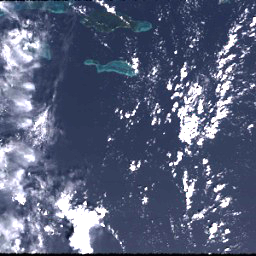

In [28]:
dataset['train']['target'][4]

In [18]:
dataset = load_from_disk('../../data/landsat/dset.hf')

README.md: 100%|██████████| 354/354 [00:00<00:00, 433kB/s]


In [ ]:
snow_segments, cloud_segments, snow_segments_binary, cloud_segments_binary = np.array(dataset['snow_segments']), np.array(dataset['cloud_segments']), np.array(dataset['snow_segments_binary']), np.array(dataset['cloud_segments_binary'])

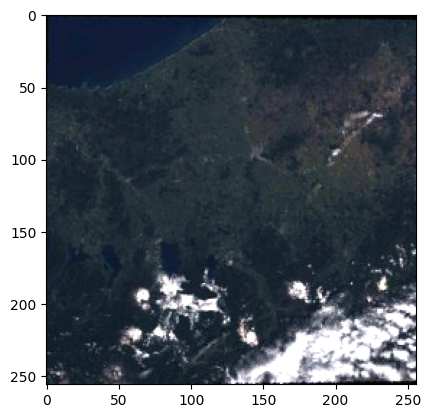

In [16]:
array = cv.imread('../../data/landsat/targets/0009178.jpg')
# show image
plt.imshow((array[:,:,::-1] * 2.6).clip(0,255).astype(np.uint8))


## Test Snowiness

In [55]:
def get_snow_segment_binary(bit_image):
    snow_pixels = (np.right_shift(bit_image,5)&1).sum()
    snow_ratio = snow_pixels / bit_image.size
    print(snow_ratio)
    if snow_ratio < 0.1:
        return 0
    else:
        return 1

In [ ]:
bit_path = '../../data/landsat/masks/0009169.npy'
bits = np.load(bit_path)
get_snow_segment_binary(bits)